In [1]:
import drawing
import numpy as np

import os

import torch 
from torch import tensor
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
print(device)


n_output_mixtures = 20
n_attn_mixtures = 10
hidden_size = 400
input_size = 3
batch_size = 128
n_epochs = 1000
timestamps = 1200
lr = 1e-5
eps = 1e-6
model_name = "20210811_Synthesis"
embedding_size = None # To be set to 73 later
base_dir = "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/"



cuda:2


In [2]:
data_dir = "data"
data = [np.load(os.path.join(data_dir, '{}.npy'.format(i))) for i in ['x', 'x_len', 'c', 'c_len', 'w_id']]
strokes_og = data[0]
stroke_lens = data[1]
strings = data[2]
string_lens = data[3]
w_id = data[4]

In [3]:
from collections import defaultdict

alphabet = [
    '\x00', ' ', '!', '"', '#', "'", '(', ')', ',', '-', '.',
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';',
    '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
    'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'Y',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
    'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
    'y', 'z'
]
vocab_size = len(alphabet)
eos_char = '\x00'
alpha_to_num = defaultdict(int, list(map(reversed, enumerate(alphabet))))
num_to_alpha = defaultdict(int, list(enumerate(alphabet)))

In [4]:
def standarize(strokes, lengths):
    points_to_consider = np.zeros((lengths.sum() - 2*len(lengths), 2))
    idx = 0
    for i in range(0, len(lengths)):
        #print(strokes[i][1:lengths[i], 0:2].shape)
        points_to_consider[idx:idx+lengths[i]-2] = strokes[i][1:lengths[i]-1, 0:2]
        idx += lengths[i] - 2
    means = points_to_consider.mean(axis=0)
    std = points_to_consider.std(axis=0)
    
    result = strokes.copy()
    for i in range(len(lengths)):
        result[i, 1:lengths[i]-1, 0:2] -= means
        result[i, 1:lengths[i]-1, 0:2] /= std
    return result, means, std

def destandarize(strokes_standarized, lengths, means, std):
    result = strokes_standarized.copy()
    for i in range(len(lengths)):
        result[i, 1:lengths[i]-1, 0:2] *= std
        result[i, 1:lengths[i]-1, 0:2] += means
    return result

def preprocess(strokes_og, stroke_lens, strings, string_lengths):
    # My preprocesisng is simple - all strokes start with (0, 0, 0) nd end with (0, 0, 1)

    # to this end we remove all full length strokes to make space for the end 
    # (0, 0, 1) as the end point

    indices = stroke_lens != 1200
    strokes_og = strokes_og[indices]
    stroke_lens = stroke_lens[indices]
    strings = strings[indices]
    string_lengths = string_lengths[indices]

    # Now we make sure that every stroke has the correct 
    # start point of (0, 0, 0) and end point of (0, 0, 1)
    strokes_og[:,0,2] = 0
    for i in range(strokes_og.shape[0]):
        strokes_og[i, stroke_lens[i], 2] = 1
    stroke_lens += 1
    
    # Standarize the coordinates separaetly to have zero mean and std dev 1
    standarized_strokes, means, std = standarize(strokes_og, stroke_lens)
    
    texts = [drawing.decode_ascii(s) + eos_char for s in strings]
    text_lengths = [len(t) for t in texts]
    
    max_text_length = max(text_lengths)
    num_texts = len(texts)
    one_hots = torch.zeros(num_texts, max_text_length, vocab_size, device=device, dtype=torch.float64)
    for i, text in enumerate(texts):
        for j, c in enumerate(text):
            one_hots[i, j, alpha_to_num[c]] = 1
    
    return standarized_strokes, means, std, stroke_lens, texts, text_lengths, one_hots, vocab_size

def string_to_one_hot(string):
    if (string[-1] != eos_char):
        string += eos_char
    one_hot = torch.zeros(len(string), vocab_size, device=device)
    for i, c in enumerate(string):
        one_hot[i, alpha_to_num[c]] = 1
    return one_hot

def one_hot_to_string(one_hot):
    # assuming that one_hot is numpy
    def get_char(arr):
        arr = list(arr)
        if 1 not in arr:
            return ''
        return num_to_alpha[list(arr).index(1)]
    return ''.join([get_char(a) for a in one_hot])

In [5]:
one_hot_to_string(string_to_one_hot("sample").cpu().numpy())

'sample\x00'

In [6]:
strokes, means, std, stroke_lengths, texts, text_lengths, one_hots, embedding_size  = preprocess(
    strokes_og, stroke_lens, strings, string_lens)
#print(strokes.shape, stroke_lengths.shape, means.shape, std.shape, texts.shape, text_lengths.shape, one_hots.shape)


In [7]:
strokes[2][stroke_lengths[2]-2:stroke_lengths[2]+2]

array([[-0.61420643, -0.1501907 ,  1.        ],
       [ 0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]], dtype=float32)

In [8]:
idx = torch.randint(low=0, high=len(texts), size=(1,)).item()
print(idx)
texts[idx]
text_lengths[idx]
one_hot_to_string(one_hots[idx])

3609


'progress I beg you to use the\x00'

30

'progress I beg you to use the\x00'

In [9]:
embedding_size

73

In [10]:
import matplotlib.pyplot as plt

def offsets_to_coords(offsets):
    """
    convert from offsets to coordinates
    """
    return np.concatenate([np.cumsum(offsets[:, :2], axis=0), offsets[:, 2:3]], axis=1)


def draw(offsets, plot_end_points=True):
    strokes = offsets_to_coords(offsets)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    stroke = []
    for x, y, eos in strokes:
        stroke.append((x, y))
        if eos == 1:
            coords = list(zip(*stroke))
            ax.plot(coords[0], coords[1], 'k')
            if plot_end_points:
                ax.plot(x, y, 'ro')
            stroke = []
    if stroke:
        coords = list(zip(*stroke))
        ax.plot(coords[0], coords[1], 'k')
        stroke = []

    padding = 10
    
    ax.set_xlim(strokes[:,0].min() - padding, strokes[:,0].max() + padding)
    ax.set_ylim(strokes[:,1].min() - padding, strokes[:,1].max() + padding)

    ax.set_aspect('equal')
    plt.tick_params(
        axis='both',
        left='off',
        top='off',
        right='off',
        bottom='off',
        labelleft='off',
        labeltop='off',
        labelright='off',
        labelbottom='off'
    )
    plt.show()
    plt.close('all')
    

def attention_plot(phis):
    plt.rcParams["figure.figsize"] = (12,6)
    phis= phis/(phis.sum(dim = 0) + eps)
    plt.xlabel('handwriting generation')
    plt.ylabel('text scanning')
    plt.imshow(phis.cpu().numpy(), cmap='hot', interpolation='nearest', aspect='auto')
    plt.show()

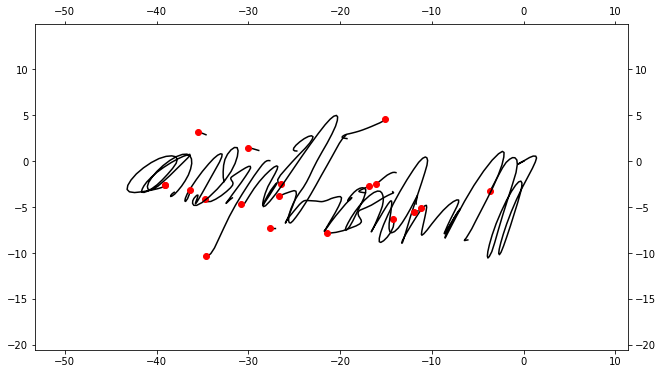

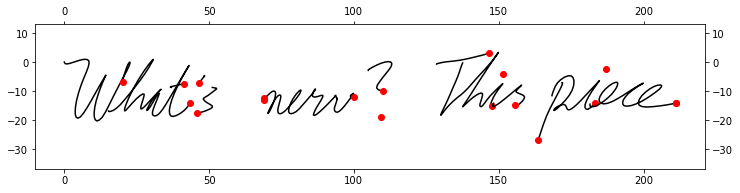

What 's new? This piece


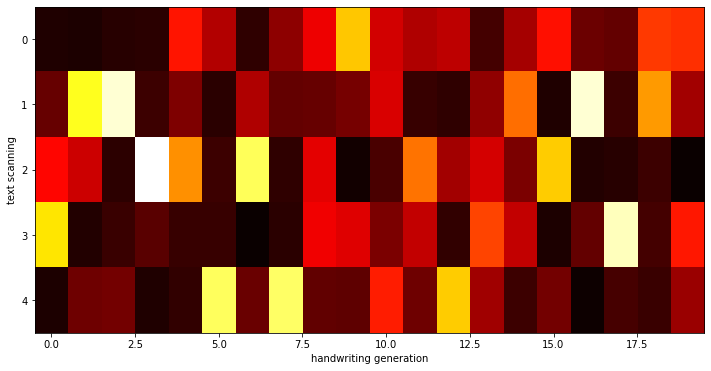

In [11]:
draw(strokes[0])
res2 = destandarize(strokes, stroke_lengths, means, std) # for checking
draw(res2[0])
print(drawing.decode_ascii(strings[0]))

attention_plot(torch.exp(torch.randn(5, 20)))

In [12]:
class HandwritingDataset(Dataset):
    def __init__(self, strokes, stroke_lengths, one_hots, text_lengths):
        assert len(strokes) == len(one_hots)
        self.strokes = strokes
        self.stroke_lengths = stroke_lengths
        self.one_hots = one_hots
        self.one_hot_lengths = text_lengths
        self.stroke_mask = self.getStrokeMask()
        self.one_hot_mask = self.getOneHotMask()
        
    def __len__(self):
        return self.strokes.shape[0]
    
    def __getitem__(self, idx):
        return self.strokes[idx], self.stroke_lengths[idx], self.stroke_mask[idx], self.one_hots[idx], self.one_hot_lengths[idx], self.one_hot_mask[idx]
    
    def getStrokeMask(self):
        mask = np.ones((self.strokes.shape[0], self.strokes.shape[1]))
        for i in range(self.strokes.shape[0]):
            # The mask is true to the string lengths.
            # Any offsets for Special training of RNN needs to be handled separately
            mask[i][self.stroke_lengths[i]:] = 0
        return mask
    
    def getOneHotMask(self):
        mask = np.ones((self.one_hots.shape[0], self.one_hots.shape[1]))
        for i in range(self.one_hots.shape[0]):
            # The mask is true to the string lengths.
            # Any offsets for Special training of RNN needs to be handled separately
            mask[i][self.one_hot_lengths[i]:] = 0
        return mask
    
train_dataset = HandwritingDataset(strokes[:-150], stroke_lengths[:-150], one_hots[:-150], text_lengths[:-150])
test_dataset = HandwritingDataset(strokes[-150:], stroke_lengths[-150:], one_hots[-150:], text_lengths[-150:])


In [13]:
# dl = DataLoader(
#     train_dataset,
#     shuffle=True,
#     batch_size=2,
#     drop_last=True)

# k = iter(dl)
# for j in range(1):
#     print("JJJJJJJJJJJJJJJJJ:", j)
#     s, l, m, oh, ohl, ohm = next(k)
#     l0 = l[0]
#     l1 = l[1]
#     l
#     s.shape
#     m.shape

#     print("Testing the 0th position of every stroke")
#     s[:,0,:]

#     print("testing the length location of stroke")
#     s[0,l0-2:l0+2, :]
#     s[1,l1-2:l1+2, :]

#     print("testing the length location of mask")
#     m[0,l0-2:l0+2]
#     m[1,l1-2:l1+2]
    
    
#     l0 = ohl[0]
#     l1 = ohl[1]
#     ohl
#     oh.shape
#     ohm.shape

#     print("Testing the 0th position of every one hot")
#     oh[:,0,:]

#     print("testing the length location of one hot")
#     oh[0,l0-2:l0+2, :]
#     oh[1,l1-2:l1+2, :]

#     print("testing the length location of mask")
#     ohm[0,l0-2:l0+2]
#     ohm[1,l1-2:l1+2]
    
    
    

In [14]:
# bs = 2
# u = torch.arange(1, 11, device=device)[None, :, None].repeat(bs, 1, 1)
# alpha = torch.rand(bs, 5)[:, None]
# beta = torch.rand(bs, 5)[:, None]
# kappa = torch.randn(bs, 5)[:, None]
# u, u.shape
# alpha, alpha.shape
# beta, beta.shape
# kappa, kappa.shape
# res = alpha * torch.exp(-beta * (kappa - u)**2)
# res.shape
# res.sum(dim=-1).shape

In [15]:
# b = torch.rand(2, 9)
# b[None].shape
# b[:, None].shape
# b[:, :, None].shape
# b.chunk(5, -1)

# a = torch.rand(2, 3, 4)
# wt = torch.randn(2, 3)[:, :, None]
# a 
# wt
# (a * wt).sum(1)

In [16]:
class GaussianAttention(nn.Module):
    def __init__(self, lstm_hidden_size, n_mixtures):
        super(GaussianAttention, self).__init__()
        self.n_mixtures = n_mixtures
        self.linear_layer = nn.Linear(lstm_hidden_size, 3*n_mixtures)
        
    def forward(self, h, kappa_prev, one_hot_batch, one_hot_mask, eps=1e-6):
        B, T = one_hot_mask.shape
        
        out_1 = self.linear_layer(h) # (B, 3*K)
        alpha, beta, kappa = torch.exp(out_1)[:, None].chunk(3, dim=-1) # (B, 1, K) each
        kappa = kappa + kappa_prev
        
        u = torch.arange(1, T+1, device="cpu")[None, :, None].repeat(B, 1, 1).to(device) # (B, T, 1)
        
        phi = alpha * torch.exp(-beta * torch.pow(kappa - u, 2)) # (B, T, K)
        phi = phi.sum(dim=-1) # (B, T)

        phi = (phi * one_hot_mask)[:, :, None] # (B, T, 1)
        
        w = (phi * one_hot_batch).sum(1) # (B, V) V = vocab_size
        
        attn_params = {
            "w": w,
            "phi": phi,
            "alpha": alpha,
            "beta": beta,
            "kappa": kappa
        }

        return attn_params
        

In [17]:
# batch_size = 2
# hidden_size = 4
# input_size = 3
# n_mixtures = 5
# vocab_size = 6
# timesteps = 7

# h = torch.randn(batch_size, hidden_size)
# kappa_prev = torch.randn(batch_size, n_mixtures)[:,None,:]
# ohb = torch.randn(batch_size, timesteps, vocab_size)
# ohm = torch.ones(batch_size, timesteps)
# ohm[0, 5:] = 0
# ohm[1, 3:] = 0
# ohm
# gl = GaussianAttention(hidden_size, n_mixtures)
# gl(h, kappa_prev, ohb, ohm)

In [18]:
from einops import rearrange 

class HandwritingSynthesis(nn.Module):
    def __init__(self, input_size, hidden_size, n_output_mixtures, n_attn_mixtures, embedding_size):
        super(HandwritingSynthesis, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_output_mixtures = n_output_mixtures
        self.n_attn_mixtures = n_attn_mixtures
        self.embedding_size = embedding_size
        self.output_size = 6*n_output_mixtures + 1
        
        self.lstm1 = nn.LSTMCell(input_size + embedding_size, hidden_size)
        self.gaussian_attn = GaussianAttention(hidden_size, n_attn_mixtures)
        self.lstm2 = nn.LSTMCell(embedding_size + input_size + hidden_size, hidden_size)
        self.linear = nn.Linear(hidden_size, self.output_size)
        
    def forward(self, stroke_t, one_hots, one_hot_mask, prev_state):
        bs = stroke_t.shape[0]
        # K: n_attn_mixtures, E: embedding_size, H: hidden_size, T: Total timesteps
        # stroke_t: (B,3), kappa: (B,1,K), attn: (B,E), hidden h and c : (B, H)
        # one_hots : (B, T, E), one_hot_mask = (B, T)
        attn_prev, kappa_prev, hid_1, hid_2 = prev_state["w"], prev_state["kappa"], prev_state["hidden_1"], prev_state["hidden_2"]
        
        hid_1 = self.lstm1(
            torch.cat([stroke_t, attn_prev], dim=-1),
            hid_1)
        
        params_new = self.gaussian_attn(
            hid_1[0],
            kappa_prev,
            one_hots,
            one_hot_mask)
        
        attn_new = params_new["w"]
        
        hid_2 = self.lstm2(
            torch.cat([stroke_t, attn_new, hid_1[0]], dim=-1),
            hid_2)
        
        out = self.linear(hid_2[0])
        
        params_new["hidden_1"] = hid_1
        params_new["hidden_2"] = hid_2
        
        return out, params_new

In [19]:
# batch_size = 2
# input_size = 3
# hidden_size = 4
# n_output_mixtures = 8
# n_attn_mixtures = 5
# embedding_size = 6
# timestamps = 7

# h = HandwritingSynthesis(input_size, hidden_size, n_output_mixtures, n_attn_mixtures, embedding_size)

# stroke = torch.randn(batch_size, 3)
# stroke[:, 2] = 0
# stroke

# one_hots = torch.zeros(batch_size, timestamps, embedding_size)
# one_hots[0,:5, 0]= 1
# one_hots[1, :3, 3] =1
# print("one_hots", one_hots)

# one_hot_mask = torch.ones(batch_size, timestamps)
# one_hot_mask[0,5:] = 0
# one_hot_mask[1,3:] = 0
# print("one_hot_mask", one_hot_mask)

# attn = {
#     "w": torch.randn(batch_size, embedding_size),
#     "phi": torch.randn(batch_size, timestamps, 1),
#     "alpha": torch.randn(batch_size, 1, n_attn_mixtures),
#     "beta": torch.randn(batch_size, 1, n_attn_mixtures),
#     "kappa": torch.randn(batch_size, 1, n_attn_mixtures)
# }
# prev_state = (attn,
#               (torch.zeros(batch_size, hidden_size), torch.zeros(batch_size, hidden_size)),
#               (torch.zeros(batch_size, hidden_size), torch.zeros(batch_size, hidden_size)))
# print("prev_state", prev_state)


# h(stroke, one_hots, one_hot_mask, prev_state)

In [20]:
def get_mixture_params_from_output(outputs, bias=0):
    # outputs:  b, max_len-1, 6*n_output_mixtures+1
    pis = nn.Softmax(2)((1+bias)*outputs[:,:,:n_output_mixtures])
    mus = rearrange(outputs[:,:,n_output_mixtures:3*n_output_mixtures], 'b l (n d) -> b l n d', d=2)
    
    sigmas = rearrange(torch.exp(outputs[:,:,3*n_output_mixtures:5*n_output_mixtures]-bias), 'b l (n d) -> b l n d', d=2) + eps
    phos = rearrange((1-eps) * torch.tanh(outputs[:,:,5*n_output_mixtures:6*n_output_mixtures]), 'b l (n d) -> b l n d', d=1)

    
    covs = torch.zeros(outputs.shape[0], outputs.shape[1], n_output_mixtures, 2, 2, device=device)
    covs[:,:,:,0,0] = sigmas[:,:,:,0]**2
    covs[:,:,:,1,1] = sigmas[:,:,:,1]**2
    covs[:,:,:,0,1] = phos[:,:,:,0] * sigmas[:,:,:,0] * sigmas[:,:,:,1]
    covs[:,:,:,1,0] = covs[:,:,:,0,1]
    
    return pis, mus, covs

def get_mixture_distributions_from_output(outputs):
    pis, mus, covs = get_mixture_params_from_output(outputs)
    
    distributions = torch.distributions.MultivariateNormal(mus, covs)
    return pis, distributions

def get_pen_lift_probs_from_output(outputs):
    return 1/(1 + torch.exp(outputs[:,:,-1]))

def nll(outputs, targets, mask_batch):
    # outputs:  b, max_len-1, 6*n_mixtures+1
    # targets: b, max_len-1, 3
    outputs = outputs.to(device)
    targets = targets.to(device)
    
    target_coords = targets[:,:,0:2].unsqueeze(2).repeat_interleave(
            torch.tensor([n_output_mixtures], device=device), dim=2)
    # target_coords: b, max_len-1, n_mixtures, 3
    stroke_lift = targets[:,:,-1] # b, max_len-1, 1
    
    pis, distributions = get_mixture_distributions_from_output(outputs)
    es = get_pen_lift_probs_from_output(outputs)

    probs = distributions.log_prob(target_coords) + eps
    loss1 = - torch.logsumexp(torch.log(pis) + probs, dim=2)
    loss2 = - torch.log(es)*stroke_lift
    loss3 = - torch.log(1 - es)*(1-stroke_lift)
    loss_per_point = loss1 + loss2 + loss3
    loss_per_point *= mask_batch
    
    return loss_per_point.sum()/outputs.shape[0]

In [21]:
def get_initial_prev_states(mode='train'):
    dim = batch_size if mode == 'train' else 1
    h01 = torch.zeros(dim, hidden_size, device=device)
    c01 = torch.zeros(dim, hidden_size, device=device)
    h02 = torch.zeros(dim, hidden_size, device=device)
    c02 = torch.zeros(dim, hidden_size, device=device)
    kappa = torch.zeros(dim, 1, n_attn_mixtures, device=device)
    w = torch.zeros(dim, embedding_size, device=device)
    
    prev_states = {
        "kappa": torch.zeros(dim, 1, n_attn_mixtures, device=device),
        "w": torch.zeros(dim, embedding_size, device=device),
        "hidden_1": (h01, c01),
        "hidden_2": (h02, c02)
    }
    return prev_states

def get_next_point(model, point_prev, text_one_hot, mask, prev_states, bias=0):
    with torch.no_grad():
        outputs, prev_states = model(point_prev.unsqueeze(0), text_one_hot, mask, prev_states)
        
        outputs = outputs[:, None]
        
        es = get_pen_lift_probs_from_output(outputs)
        pis, mus, covs = get_mixture_params_from_output(outputs, bias=0)
        
        sample_index = 0
        if n_output_mixtures > 1:
            sample_index = np.random.choice(
                range(n_output_mixtures),
                p = pis.squeeze().cpu().numpy())

        pen_off = torch.tensor(
            [np.random.binomial(1,es.item())],
            device=device)

        sample_point = torch.tensor(
            np.random.multivariate_normal(
                mus.squeeze(0).squeeze(0)[sample_index].cpu().numpy(),
                covs.squeeze(0).squeeze(0)[sample_index].cpu().numpy()),
            device=device)
        
        return torch.cat((sample_point, pen_off), dim=0), prev_states
        
def sample(model, text, bias=0):
    timestamps = 1200
    text_one_hot = string_to_one_hot(text)[None]
    mask = torch.ones(1, text_one_hot.shape[1], device=device)
    sample_stroke = torch.zeros(timestamps, 3, device=device)
    prev_states = get_initial_prev_states("sample")

    phis = []
    for i in range(timestamps-2):
        prev_point = sample_stroke[i]
        new_point, prev_states = get_next_point(model, prev_point, text_one_hot, mask, prev_states, bias=0)
        phis.append(prev_states["phi"].squeeze()[None])
        sample_stroke[i+1] = new_point
    phis = torch.cat(phis, dim=0).T
    return sample_stroke, phis



In [22]:
from einops import rearrange

def get_inputs_targets_mask(strokes_batch, strokes_mask):
    inputs = strokes_batch[:, :-1, :]
    targets = strokes_batch[:, 1:, :]
    mask = strokes_mask[:, 1:]
    return inputs, targets, mask

def train_batch(model,
                optimizer,
                strokes,
                strokes_mask,
                one_hots,
                one_hots_mask,
                prev_states,
                output_holder):
    
    optimizer.zero_grad()
    
    inputs, targets, mask = get_inputs_targets_mask(strokes, strokes_mask)
    
    T = inputs.shape[1]
    
    for t in range(T): 
        output_holder[t], prev_states = model(
            inputs[:, t, :],
            one_hots,
            one_hots_mask,
            prev_states)
    loss = nll(rearrange(output_holder, 'T B S -> B T S'), targets, mask)
    loss.backward()
    
    #### Do Gradient clipping here if need be
    torch.nn.utils.clip_grad_value_(model.parameters(), 10)
    torch.nn.utils.clip_grad_value_(loss, 100)
    
    optimizer.step()
    return loss.item()

def save_model(model, model_name):
    torch.save({
        'model_state_dict': model.state_dict(),
    }, base_dir + model_name)
    
def detach(x):
    if type(x) is tuple:
        return (x[0], x[1])
    if type(x) is dict:
        d = {}
        for k in x:
            d[k] = x[k].detach()
        return d
    return x.detach()
    
def train(model, optimizer, train_dataloader, num_epochs):
    losses = []
    n_iter = 0
    total_loss = 0
    start = time.time()
    
    print_every = 50
    sample_every = print_every * 5
    
    prev_states = get_initial_prev_states("train")
    output_holder = torch.zeros(timestamps-1, batch_size, 6*n_output_mixtures+1, device=device).float()
    for epoch in range(num_epochs):
        
        for strokes, _, strokes_mask, one_hots, _, one_hots_mask in train_dataloader:
            strokes = strokes.to(device).float()
            strokes_mask = strokes_mask.to(device).float()
            one_hots = one_hots.to(device).float()
            one_hots_mask = one_hots_mask.to(device).float()
            
            batch_loss = train_batch(
                model,
                optimizer,
                strokes,
                strokes_mask,
                one_hots,
                one_hots_mask,
                prev_states,
                output_holder)
            
            for k in prev_states:
                prev_states[k] = detach(prev_states[k])
                
            output_holder = output_holder.detach()
            
            total_loss += batch_loss
            
            if n_iter % print_every == 0:
                avg_loss = total_loss/print_every
                losses.append(avg_loss)
                print(f"iteration: {n_iter} "\
                      f"of {len(train_dataloader) * num_epochs}, " \
                      f"avg_loss: {avg_loss:.2f}, "\
                      f"timeSinceStart: {time.time() - start :.2f}, "\
                      f"Epoch: {epoch}")
                total_loss = 0
                save_model(model, model_name)
                
            if n_iter % sample_every == 0:
                    text = "Can you write this please?"
                    sample_stroke, phis = sample(model, text, bias=0.5)
                    print(text)
                    sample_stroke[1:, 0:2] *= torch.tensor(std, device=device)
                    sample_stroke[1:, 0:2] += torch.tensor(means, device=device)
                    draw(sample_stroke.cpu(), plot_end_points=False)
                    attention_plot(phis)
                
            n_iter += 1
    return losses

In [23]:
# model_names = ["model_with_attention.pt", "model_with_attention_bs_32.pt", "model_with_attention_bs_64.pt"]
# base_dir = "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/"

# def load_model(path):
#     model = HandWritingSynthesis(3, 500, 73, 20, 3)
#     checkpoint = torch.load(path)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     return model

# models = [(model_name, load_model(base_dir + model_name)) for model_name in model_names]


In [24]:
load_previous_state = True
model = HandwritingSynthesis(input_size, hidden_size, n_output_mixtures, n_attn_mixtures, embedding_size).to(device)
if load_previous_state:
    checkpoint = torch.load(base_dir + model_name)
    model.load_state_dict(checkpoint['model_state_dict'])
optim = torch.optim.Adam(model.parameters(), lr = lr)
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=batch_size,
    drop_last=True)


<All keys matched successfully>

/home/miniconda3/lib/python3.8/site-packages/torch/_tensor.py:992: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  /opt/conda/conda-bld/pytorch_1627542741873/work/build/aten/src/ATen/core/TensorBody.h:802.)
  return self._grad


iteration: 0 of 91000, avg_loss: -40.63, timeSinceStart: 3.53, Epoch: 0
Can you write this please?


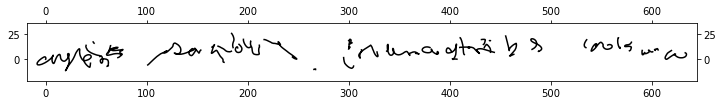

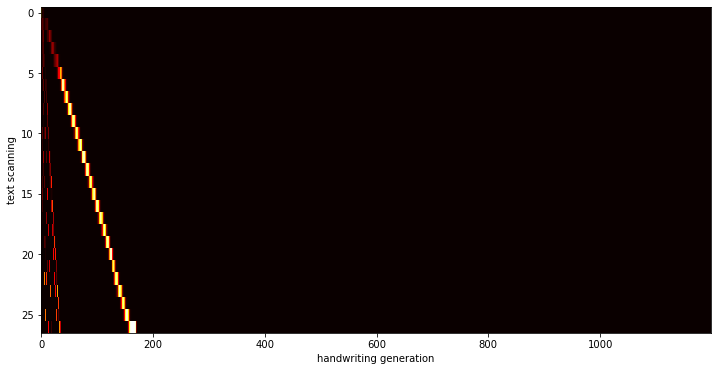

iteration: 50 of 91000, avg_loss: -2032.39, timeSinceStart: 109.70, Epoch: 0
iteration: 100 of 91000, avg_loss: -2059.79, timeSinceStart: 213.56, Epoch: 1
iteration: 150 of 91000, avg_loss: -2057.33, timeSinceStart: 316.29, Epoch: 1
iteration: 200 of 91000, avg_loss: -2065.77, timeSinceStart: 419.59, Epoch: 2
iteration: 250 of 91000, avg_loss: -2057.06, timeSinceStart: 522.74, Epoch: 2
Can you write this please?


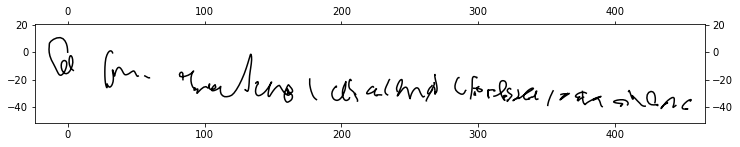

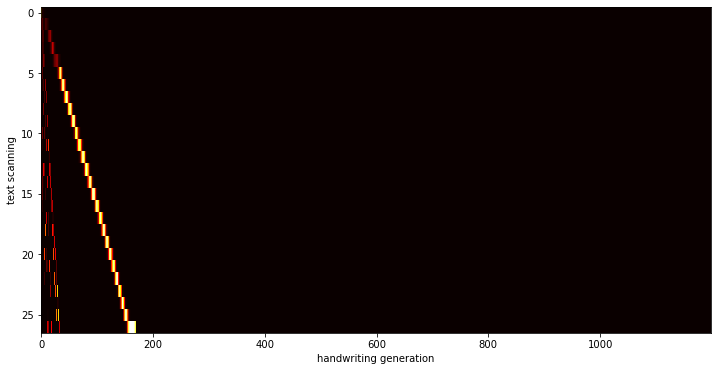

iteration: 300 of 91000, avg_loss: -2055.22, timeSinceStart: 627.32, Epoch: 3
iteration: 350 of 91000, avg_loss: -2058.01, timeSinceStart: 729.81, Epoch: 3
iteration: 400 of 91000, avg_loss: -2053.78, timeSinceStart: 832.34, Epoch: 4
iteration: 450 of 91000, avg_loss: -2060.32, timeSinceStart: 934.79, Epoch: 4
iteration: 500 of 91000, avg_loss: -2059.81, timeSinceStart: 1037.24, Epoch: 5
Can you write this please?


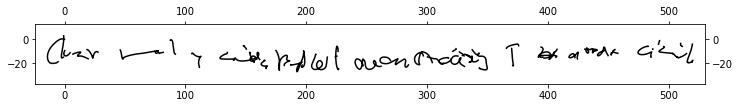

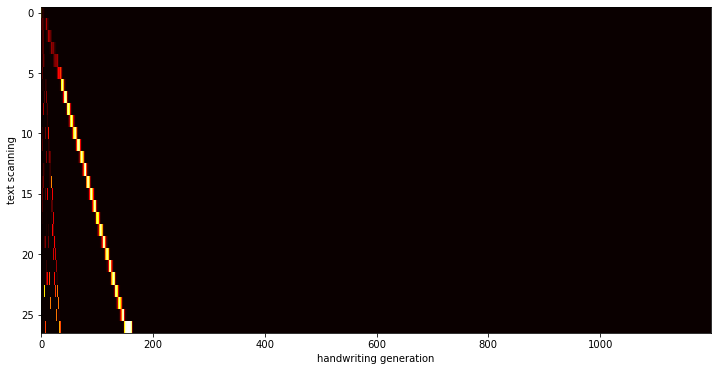

iteration: 550 of 91000, avg_loss: -2057.42, timeSinceStart: 1142.45, Epoch: 6
iteration: 600 of 91000, avg_loss: -2053.56, timeSinceStart: 1245.65, Epoch: 6
iteration: 650 of 91000, avg_loss: -2058.08, timeSinceStart: 1348.65, Epoch: 7
iteration: 700 of 91000, avg_loss: -2059.50, timeSinceStart: 1452.25, Epoch: 7
iteration: 750 of 91000, avg_loss: -2058.37, timeSinceStart: 1555.87, Epoch: 8
Can you write this please?


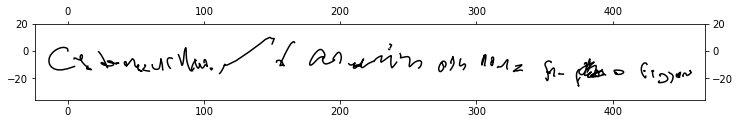

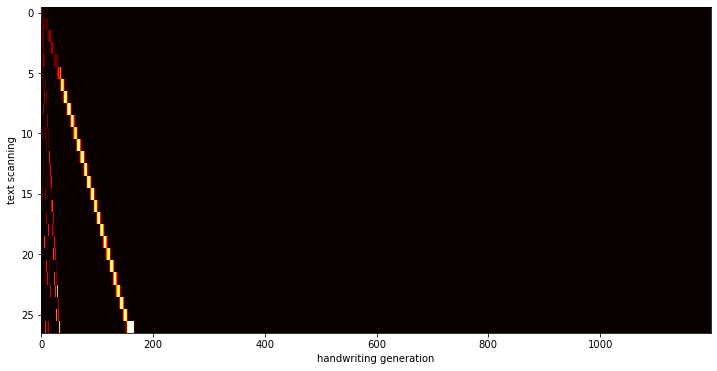

iteration: 800 of 91000, avg_loss: -2055.21, timeSinceStart: 1661.43, Epoch: 8
iteration: 850 of 91000, avg_loss: -2060.15, timeSinceStart: 1764.86, Epoch: 9
iteration: 900 of 91000, avg_loss: -2052.16, timeSinceStart: 1868.56, Epoch: 9
iteration: 950 of 91000, avg_loss: -2063.66, timeSinceStart: 1971.83, Epoch: 10
iteration: 1000 of 91000, avg_loss: -2056.96, timeSinceStart: 2075.47, Epoch: 10
Can you write this please?


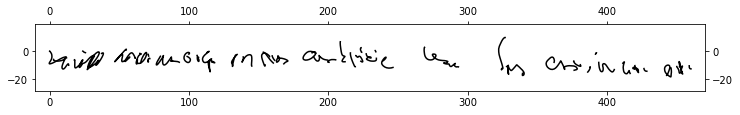

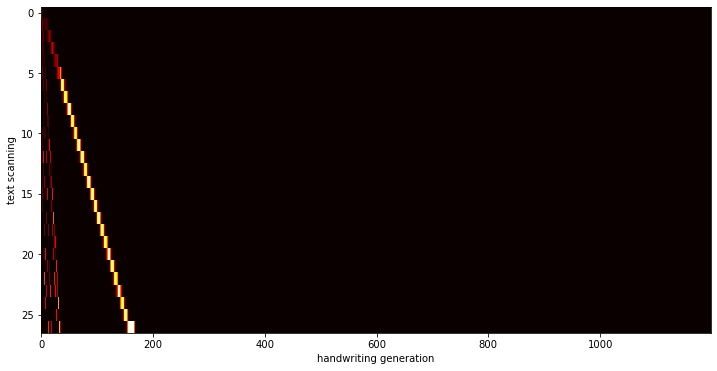

iteration: 1050 of 91000, avg_loss: -2059.90, timeSinceStart: 2180.84, Epoch: 11
iteration: 1100 of 91000, avg_loss: -2056.35, timeSinceStart: 2284.38, Epoch: 12
iteration: 1150 of 91000, avg_loss: -2059.19, timeSinceStart: 2387.93, Epoch: 12
iteration: 1200 of 91000, avg_loss: -2058.71, timeSinceStart: 2490.98, Epoch: 13
iteration: 1250 of 91000, avg_loss: -2055.53, timeSinceStart: 2594.37, Epoch: 13
Can you write this please?


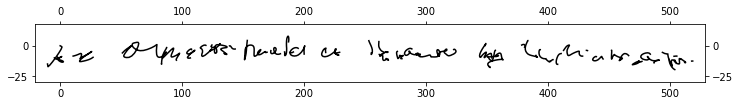

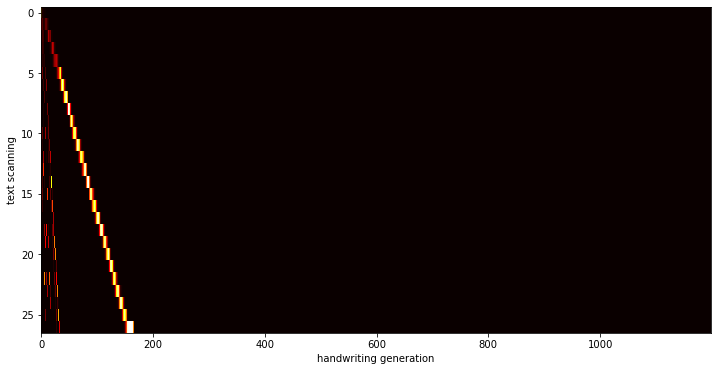

iteration: 1300 of 91000, avg_loss: -2065.17, timeSinceStart: 2699.25, Epoch: 14
iteration: 1350 of 91000, avg_loss: -2061.70, timeSinceStart: 2802.14, Epoch: 14
iteration: 1400 of 91000, avg_loss: -2048.80, timeSinceStart: 2905.51, Epoch: 15
iteration: 1450 of 91000, avg_loss: -2059.98, timeSinceStart: 3008.13, Epoch: 15
iteration: 1500 of 91000, avg_loss: -2066.97, timeSinceStart: 3110.63, Epoch: 16
Can you write this please?


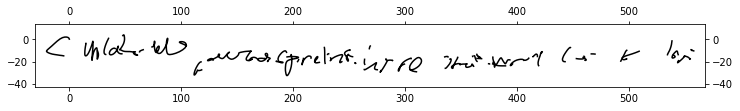

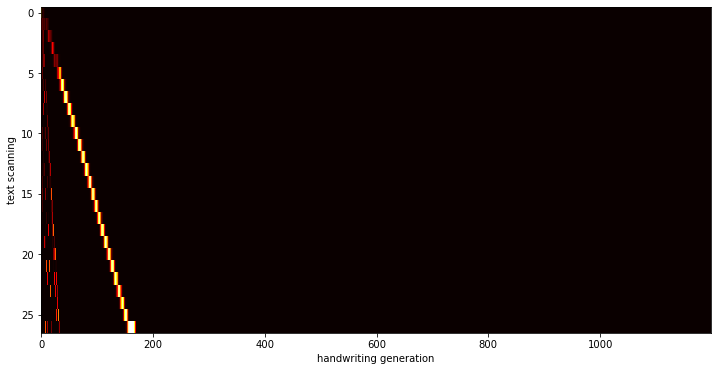

iteration: 1550 of 91000, avg_loss: -2053.72, timeSinceStart: 3215.31, Epoch: 17
iteration: 1600 of 91000, avg_loss: -2056.80, timeSinceStart: 3317.81, Epoch: 17
iteration: 1650 of 91000, avg_loss: -2059.11, timeSinceStart: 3420.07, Epoch: 18
iteration: 1700 of 91000, avg_loss: -2059.67, timeSinceStart: 3522.40, Epoch: 18
iteration: 1750 of 91000, avg_loss: -2059.46, timeSinceStart: 3625.61, Epoch: 19
Can you write this please?


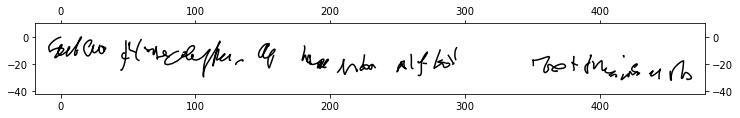

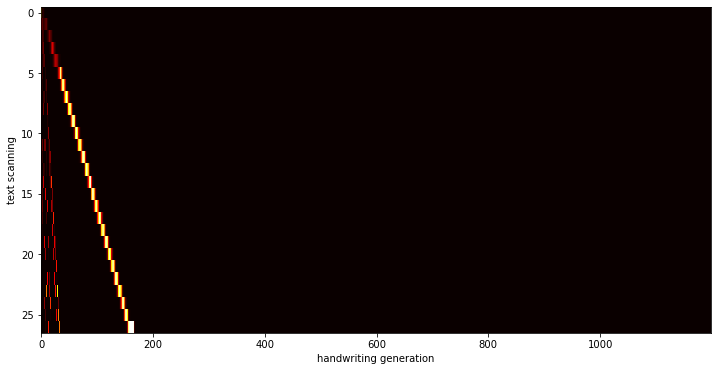

iteration: 1800 of 91000, avg_loss: -2058.18, timeSinceStart: 3731.22, Epoch: 19
iteration: 1850 of 91000, avg_loss: -2056.63, timeSinceStart: 3834.41, Epoch: 20
iteration: 1900 of 91000, avg_loss: -2062.30, timeSinceStart: 3937.54, Epoch: 20
iteration: 1950 of 91000, avg_loss: -2061.81, timeSinceStart: 4040.53, Epoch: 21
iteration: 2000 of 91000, avg_loss: -2057.01, timeSinceStart: 4143.15, Epoch: 21
Can you write this please?


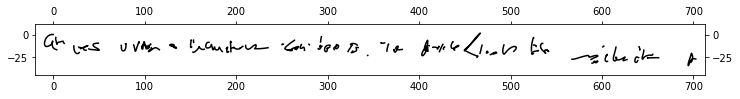

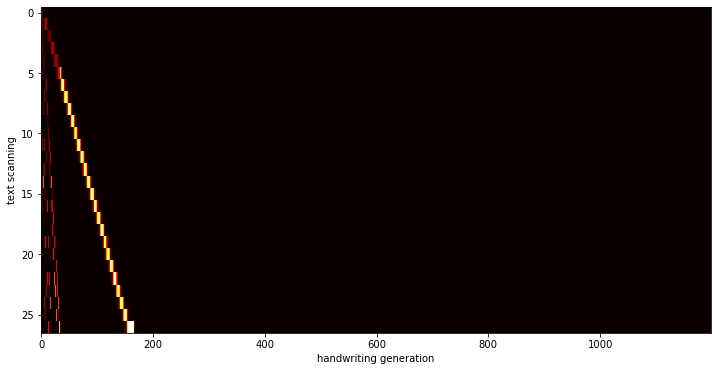

iteration: 2050 of 91000, avg_loss: -2042.56, timeSinceStart: 4247.86, Epoch: 22
iteration: 2100 of 91000, avg_loss: -2076.55, timeSinceStart: 4351.59, Epoch: 23
iteration: 2150 of 91000, avg_loss: -2060.43, timeSinceStart: 4454.29, Epoch: 23
iteration: 2200 of 91000, avg_loss: -2053.81, timeSinceStart: 4557.22, Epoch: 24
iteration: 2250 of 91000, avg_loss: -2070.76, timeSinceStart: 4660.54, Epoch: 24
Can you write this please?


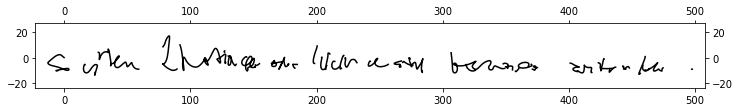

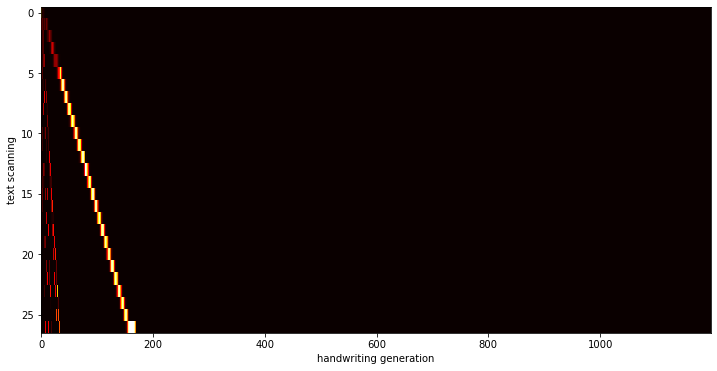

iteration: 2300 of 91000, avg_loss: -2059.11, timeSinceStart: 4766.13, Epoch: 25
iteration: 2350 of 91000, avg_loss: -2051.30, timeSinceStart: 4869.57, Epoch: 25
iteration: 2400 of 91000, avg_loss: -2080.85, timeSinceStart: 4972.99, Epoch: 26
iteration: 2450 of 91000, avg_loss: -2045.36, timeSinceStart: 5076.86, Epoch: 26
iteration: 2500 of 91000, avg_loss: -2062.20, timeSinceStart: 5180.41, Epoch: 27
Can you write this please?


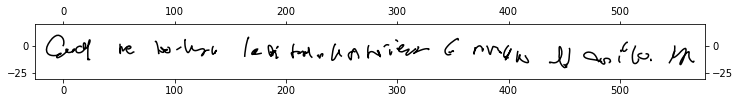

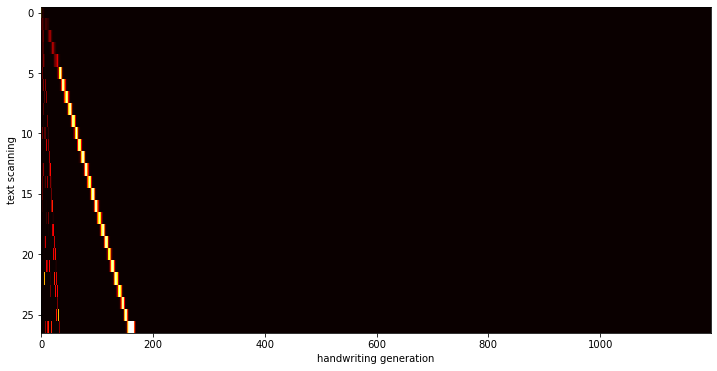

iteration: 2550 of 91000, avg_loss: -2051.54, timeSinceStart: 5285.68, Epoch: 28
iteration: 2600 of 91000, avg_loss: -2052.10, timeSinceStart: 5388.30, Epoch: 28
iteration: 2650 of 91000, avg_loss: -2068.07, timeSinceStart: 5491.82, Epoch: 29
iteration: 2700 of 91000, avg_loss: -2068.42, timeSinceStart: 5595.31, Epoch: 29
iteration: 2750 of 91000, avg_loss: -2048.46, timeSinceStart: 5698.32, Epoch: 30
Can you write this please?


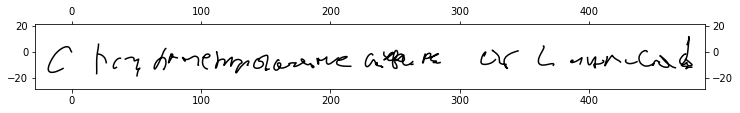

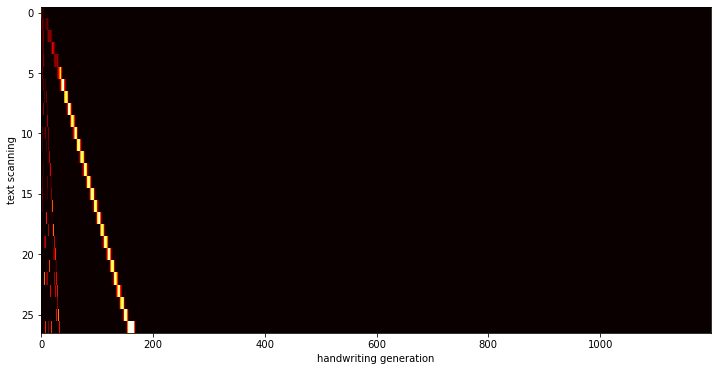

iteration: 2800 of 91000, avg_loss: -2067.76, timeSinceStart: 5803.21, Epoch: 30
iteration: 2850 of 91000, avg_loss: -2053.67, timeSinceStart: 5906.07, Epoch: 31
iteration: 2900 of 91000, avg_loss: -2060.18, timeSinceStart: 6008.95, Epoch: 31
iteration: 2950 of 91000, avg_loss: -2062.00, timeSinceStart: 6112.64, Epoch: 32
iteration: 3000 of 91000, avg_loss: -2056.09, timeSinceStart: 6215.69, Epoch: 32
Can you write this please?


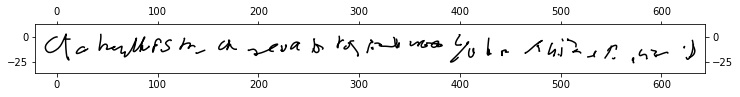

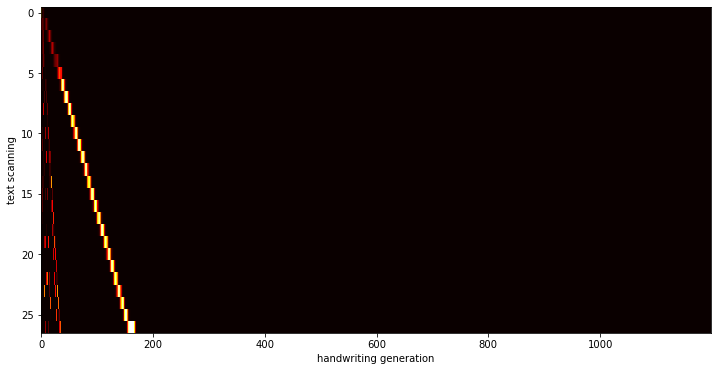

iteration: 3050 of 91000, avg_loss: -2061.69, timeSinceStart: 6320.76, Epoch: 33
iteration: 3100 of 91000, avg_loss: -2057.99, timeSinceStart: 6423.67, Epoch: 34
iteration: 3150 of 91000, avg_loss: -2062.74, timeSinceStart: 6526.21, Epoch: 34
iteration: 3200 of 91000, avg_loss: -2052.19, timeSinceStart: 6628.69, Epoch: 35
iteration: 3250 of 91000, avg_loss: -2064.43, timeSinceStart: 6731.31, Epoch: 35
Can you write this please?


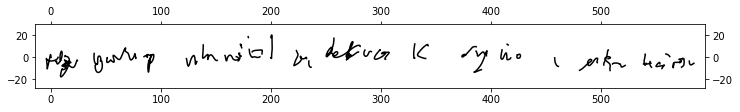

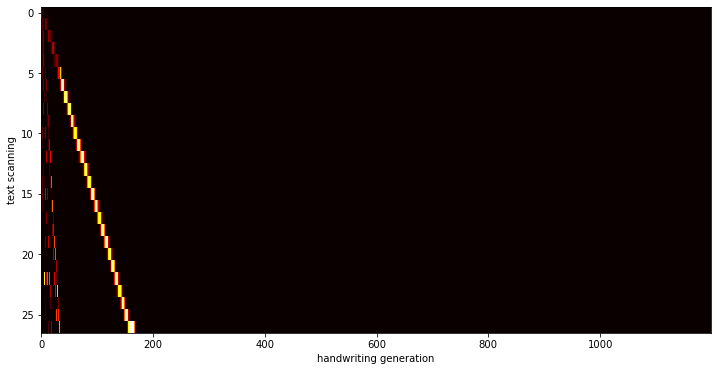

iteration: 3300 of 91000, avg_loss: -2057.03, timeSinceStart: 6837.02, Epoch: 36
iteration: 3350 of 91000, avg_loss: -2062.41, timeSinceStart: 6939.80, Epoch: 36
iteration: 3400 of 91000, avg_loss: -2055.30, timeSinceStart: 7043.09, Epoch: 37
iteration: 3450 of 91000, avg_loss: -2062.32, timeSinceStart: 7146.23, Epoch: 37
iteration: 3500 of 91000, avg_loss: -2058.75, timeSinceStart: 7249.70, Epoch: 38
Can you write this please?


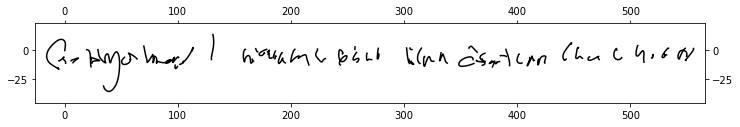

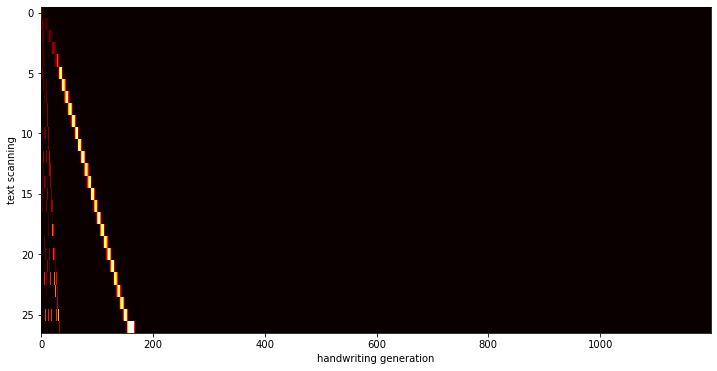

iteration: 3550 of 91000, avg_loss: -2067.87, timeSinceStart: 7355.06, Epoch: 39
iteration: 3600 of 91000, avg_loss: -2064.07, timeSinceStart: 7458.64, Epoch: 39
iteration: 3650 of 91000, avg_loss: -2051.18, timeSinceStart: 7561.83, Epoch: 40
iteration: 3700 of 91000, avg_loss: -2060.49, timeSinceStart: 7664.58, Epoch: 40
iteration: 3750 of 91000, avg_loss: -2065.08, timeSinceStart: 7768.26, Epoch: 41
Can you write this please?


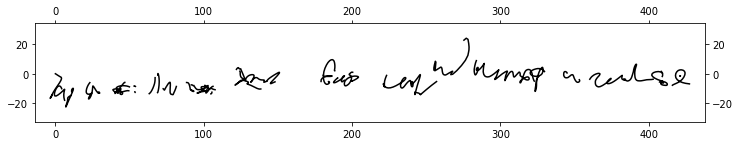

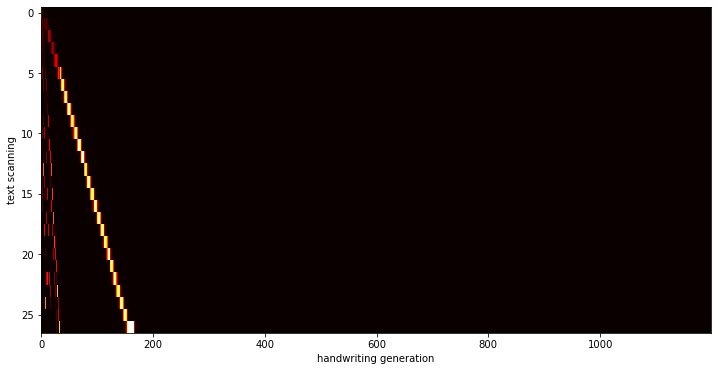

iteration: 3800 of 91000, avg_loss: -2043.72, timeSinceStart: 7873.22, Epoch: 41
iteration: 3850 of 91000, avg_loss: -2075.47, timeSinceStart: 7975.68, Epoch: 42
iteration: 3900 of 91000, avg_loss: -2057.97, timeSinceStart: 8078.72, Epoch: 42
iteration: 3950 of 91000, avg_loss: -2058.76, timeSinceStart: 8182.31, Epoch: 43
iteration: 4000 of 91000, avg_loss: -2058.23, timeSinceStart: 8284.71, Epoch: 43
Can you write this please?


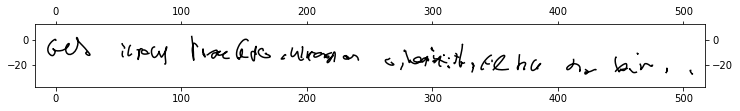

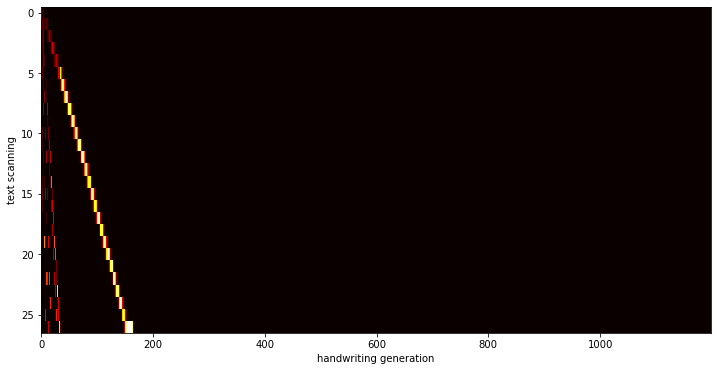

iteration: 4050 of 91000, avg_loss: -2059.15, timeSinceStart: 8390.20, Epoch: 44
iteration: 4100 of 91000, avg_loss: -2059.87, timeSinceStart: 8493.06, Epoch: 45
iteration: 4150 of 91000, avg_loss: -2072.21, timeSinceStart: 8596.00, Epoch: 45
iteration: 4200 of 91000, avg_loss: -2049.89, timeSinceStart: 8699.22, Epoch: 46
iteration: 4250 of 91000, avg_loss: -2055.67, timeSinceStart: 8802.77, Epoch: 46
Can you write this please?


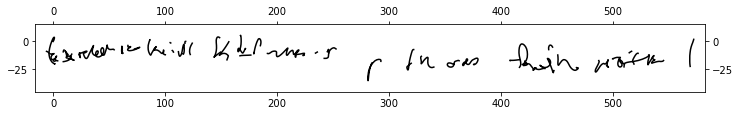

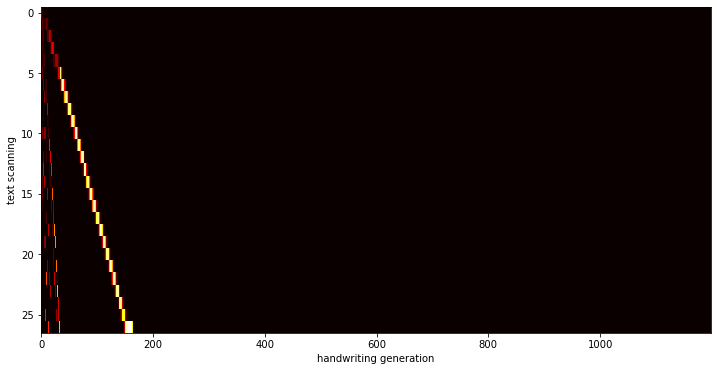

iteration: 4300 of 91000, avg_loss: -2065.68, timeSinceStart: 8907.70, Epoch: 47
iteration: 4350 of 91000, avg_loss: -2070.91, timeSinceStart: 9010.40, Epoch: 47
iteration: 4400 of 91000, avg_loss: -2058.68, timeSinceStart: 9112.79, Epoch: 48
iteration: 4450 of 91000, avg_loss: -2049.60, timeSinceStart: 9215.32, Epoch: 48
iteration: 4500 of 91000, avg_loss: -2072.96, timeSinceStart: 9318.64, Epoch: 49
Can you write this please?


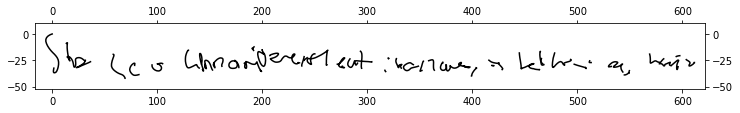

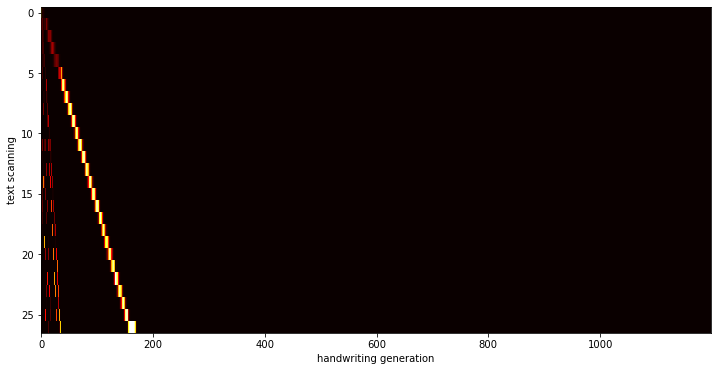

iteration: 4550 of 91000, avg_loss: -2058.81, timeSinceStart: 9424.11, Epoch: 50
iteration: 4600 of 91000, avg_loss: -2059.33, timeSinceStart: 9526.43, Epoch: 50
iteration: 4650 of 91000, avg_loss: -2053.06, timeSinceStart: 9629.93, Epoch: 51
iteration: 4700 of 91000, avg_loss: -2062.37, timeSinceStart: 9732.85, Epoch: 51
iteration: 4750 of 91000, avg_loss: -2063.94, timeSinceStart: 9836.33, Epoch: 52
Can you write this please?


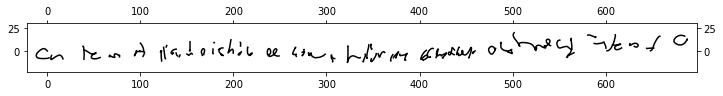

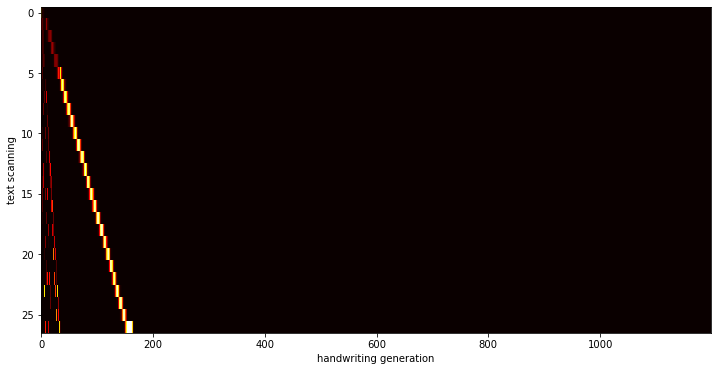

iteration: 4800 of 91000, avg_loss: -2061.49, timeSinceStart: 9941.79, Epoch: 52
iteration: 4850 of 91000, avg_loss: -2068.96, timeSinceStart: 10045.36, Epoch: 53
iteration: 4900 of 91000, avg_loss: -2050.26, timeSinceStart: 10148.76, Epoch: 53
iteration: 4950 of 91000, avg_loss: -2056.66, timeSinceStart: 10252.36, Epoch: 54
iteration: 5000 of 91000, avg_loss: -2068.20, timeSinceStart: 10355.18, Epoch: 54
Can you write this please?


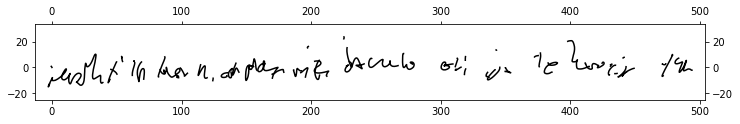

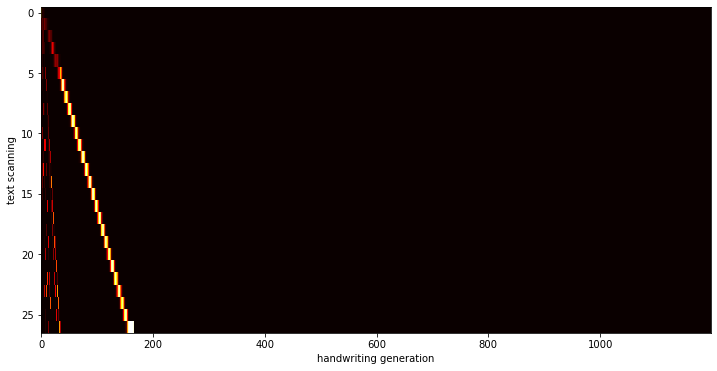

iteration: 5050 of 91000, avg_loss: -2064.14, timeSinceStart: 10460.49, Epoch: 55
iteration: 5100 of 91000, avg_loss: -2065.88, timeSinceStart: 10563.76, Epoch: 56
iteration: 5150 of 91000, avg_loss: -2069.88, timeSinceStart: 10666.96, Epoch: 56
iteration: 5200 of 91000, avg_loss: -2055.59, timeSinceStart: 10769.89, Epoch: 57
iteration: 5250 of 91000, avg_loss: -2059.79, timeSinceStart: 10873.11, Epoch: 57
Can you write this please?


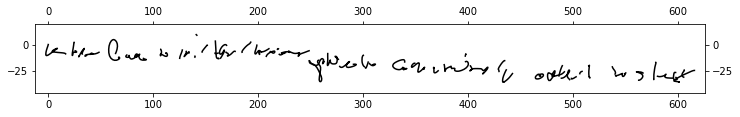

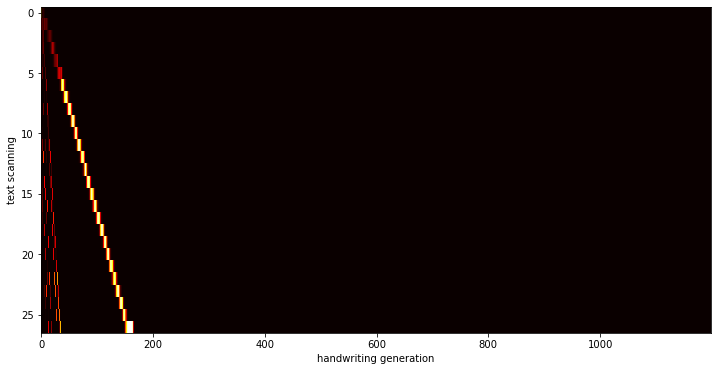

iteration: 5300 of 91000, avg_loss: -2059.18, timeSinceStart: 10978.33, Epoch: 58
iteration: 5350 of 91000, avg_loss: -2062.67, timeSinceStart: 11080.97, Epoch: 58
iteration: 5400 of 91000, avg_loss: -2066.98, timeSinceStart: 11184.55, Epoch: 59
iteration: 5450 of 91000, avg_loss: -2052.47, timeSinceStart: 11287.99, Epoch: 59
iteration: 5500 of 91000, avg_loss: -2072.13, timeSinceStart: 11391.54, Epoch: 60
Can you write this please?


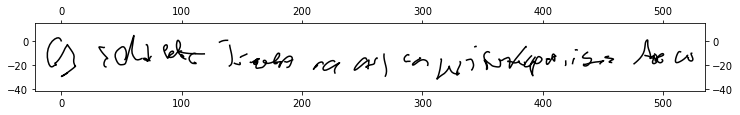

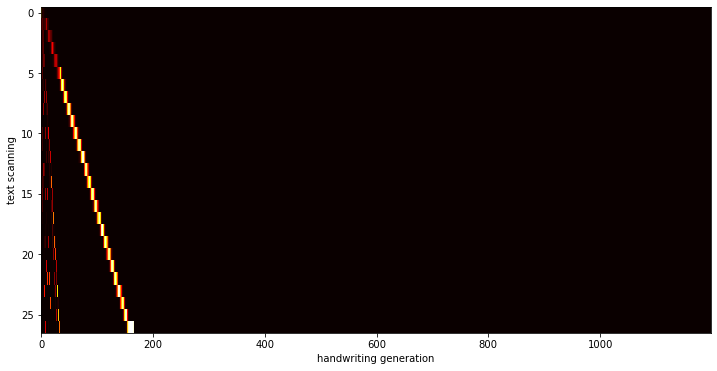

iteration: 5550 of 91000, avg_loss: -2056.52, timeSinceStart: 11496.91, Epoch: 60
iteration: 5600 of 91000, avg_loss: -2062.03, timeSinceStart: 11600.35, Epoch: 61
iteration: 5650 of 91000, avg_loss: -2058.99, timeSinceStart: 11703.44, Epoch: 62
iteration: 5700 of 91000, avg_loss: -2066.65, timeSinceStart: 11805.75, Epoch: 62
iteration: 5750 of 91000, avg_loss: -2065.20, timeSinceStart: 11908.13, Epoch: 63
Can you write this please?


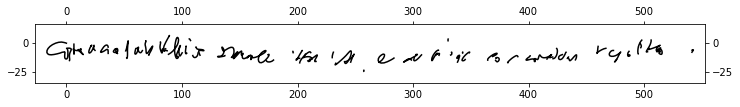

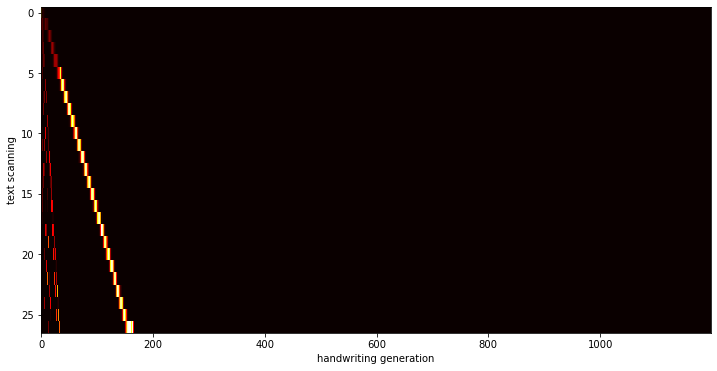

iteration: 5800 of 91000, avg_loss: -2068.35, timeSinceStart: 12012.28, Epoch: 63
iteration: 5850 of 91000, avg_loss: -2056.16, timeSinceStart: 12114.42, Epoch: 64
iteration: 5900 of 91000, avg_loss: -2056.65, timeSinceStart: 12216.50, Epoch: 64
iteration: 5950 of 91000, avg_loss: -2064.12, timeSinceStart: 12319.81, Epoch: 65
iteration: 6000 of 91000, avg_loss: -2064.21, timeSinceStart: 12422.02, Epoch: 65
Can you write this please?


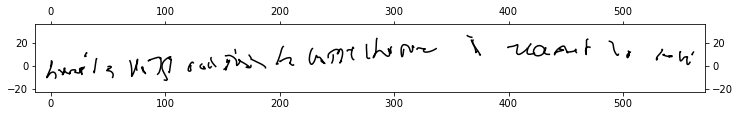

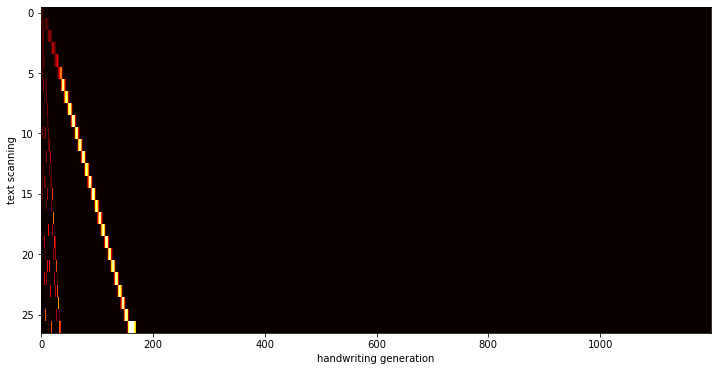

iteration: 6050 of 91000, avg_loss: -2054.86, timeSinceStart: 12526.56, Epoch: 66
iteration: 6100 of 91000, avg_loss: -2063.42, timeSinceStart: 12629.69, Epoch: 67
iteration: 6150 of 91000, avg_loss: -2068.94, timeSinceStart: 12732.87, Epoch: 67
iteration: 6200 of 91000, avg_loss: -2057.21, timeSinceStart: 12835.83, Epoch: 68
iteration: 6250 of 91000, avg_loss: -2064.99, timeSinceStart: 12939.21, Epoch: 68
Can you write this please?


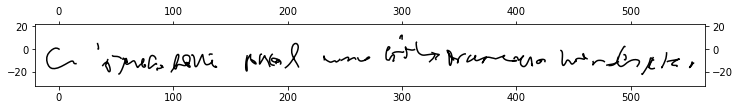

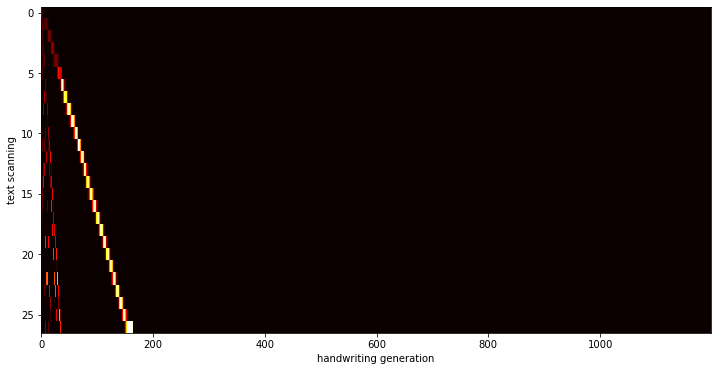

iteration: 6300 of 91000, avg_loss: -2063.75, timeSinceStart: 13044.33, Epoch: 69
iteration: 6350 of 91000, avg_loss: -2055.64, timeSinceStart: 13147.44, Epoch: 69
iteration: 6400 of 91000, avg_loss: -2063.52, timeSinceStart: 13250.38, Epoch: 70
iteration: 6450 of 91000, avg_loss: -2069.76, timeSinceStart: 13353.37, Epoch: 70
iteration: 6500 of 91000, avg_loss: -2063.41, timeSinceStart: 13456.80, Epoch: 71
Can you write this please?


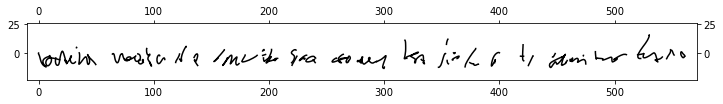

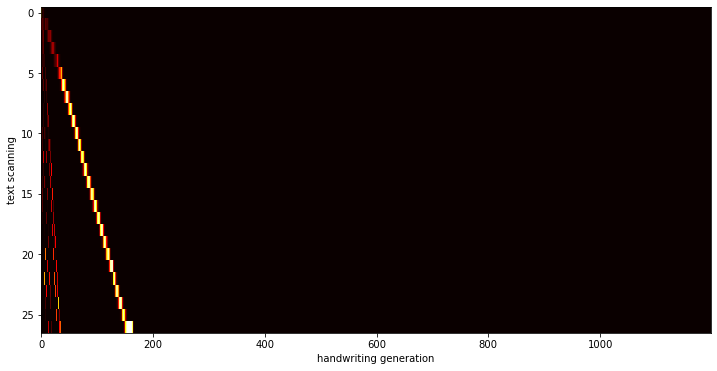

iteration: 6550 of 91000, avg_loss: -2056.44, timeSinceStart: 13561.85, Epoch: 71
iteration: 6600 of 91000, avg_loss: -2074.58, timeSinceStart: 13665.07, Epoch: 72
iteration: 6650 of 91000, avg_loss: -2052.89, timeSinceStart: 13768.42, Epoch: 73
iteration: 6700 of 91000, avg_loss: -2067.58, timeSinceStart: 13871.52, Epoch: 73
iteration: 6750 of 91000, avg_loss: -2051.96, timeSinceStart: 13974.84, Epoch: 74
Can you write this please?


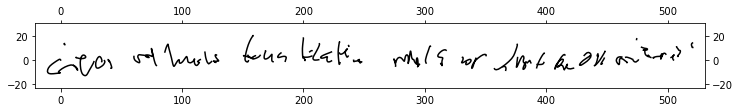

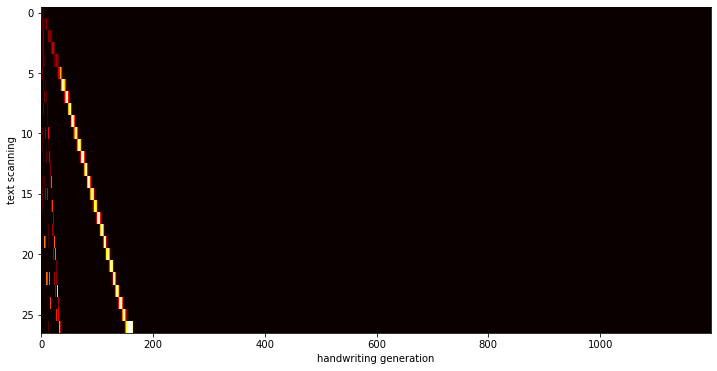

iteration: 6800 of 91000, avg_loss: -2058.31, timeSinceStart: 14080.36, Epoch: 74
iteration: 6850 of 91000, avg_loss: -2073.83, timeSinceStart: 14183.10, Epoch: 75
iteration: 6900 of 91000, avg_loss: -2067.70, timeSinceStart: 14286.24, Epoch: 75
iteration: 6950 of 91000, avg_loss: -2048.42, timeSinceStart: 14388.85, Epoch: 76
iteration: 7000 of 91000, avg_loss: -2068.02, timeSinceStart: 14492.39, Epoch: 76
Can you write this please?


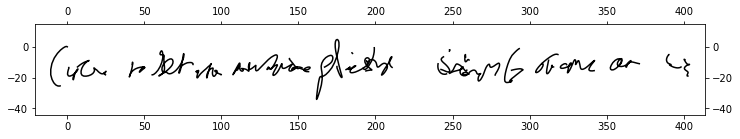

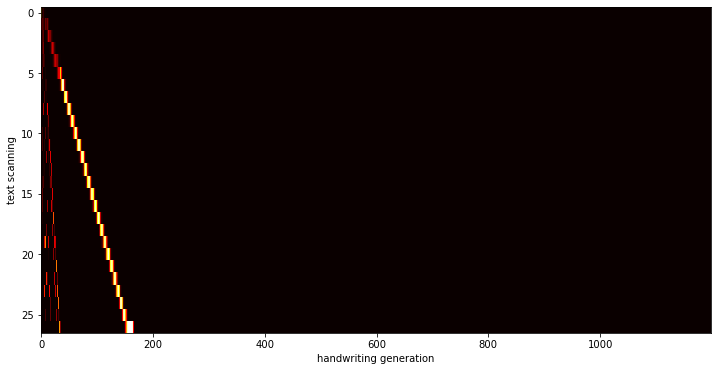

iteration: 7050 of 91000, avg_loss: -2057.26, timeSinceStart: 14598.05, Epoch: 77
iteration: 7100 of 91000, avg_loss: -2071.53, timeSinceStart: 14701.77, Epoch: 78
iteration: 7150 of 91000, avg_loss: -2049.42, timeSinceStart: 14805.23, Epoch: 78
iteration: 7200 of 91000, avg_loss: -2070.82, timeSinceStart: 14907.74, Epoch: 79
iteration: 7250 of 91000, avg_loss: -2065.03, timeSinceStart: 15011.13, Epoch: 79
Can you write this please?


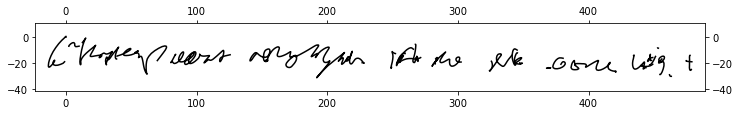

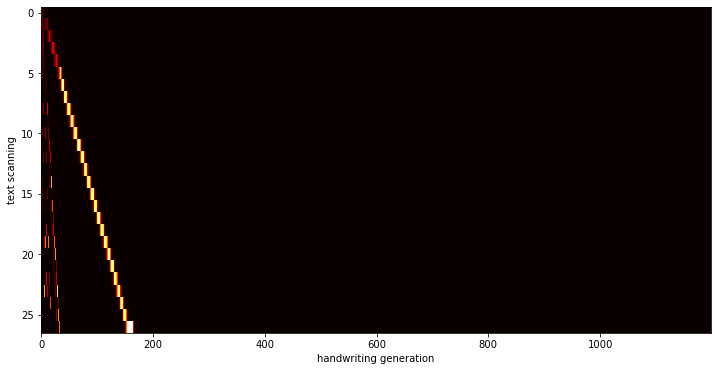

iteration: 7300 of 91000, avg_loss: -2059.17, timeSinceStart: 15115.73, Epoch: 80
iteration: 7350 of 91000, avg_loss: -2063.68, timeSinceStart: 15218.56, Epoch: 80
iteration: 7400 of 91000, avg_loss: -2060.72, timeSinceStart: 15321.97, Epoch: 81
iteration: 7450 of 91000, avg_loss: -2062.95, timeSinceStart: 15424.97, Epoch: 81
iteration: 7500 of 91000, avg_loss: -2065.62, timeSinceStart: 15527.50, Epoch: 82
Can you write this please?


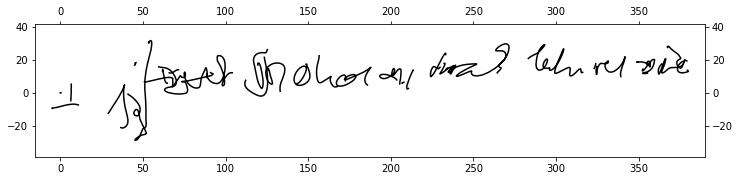

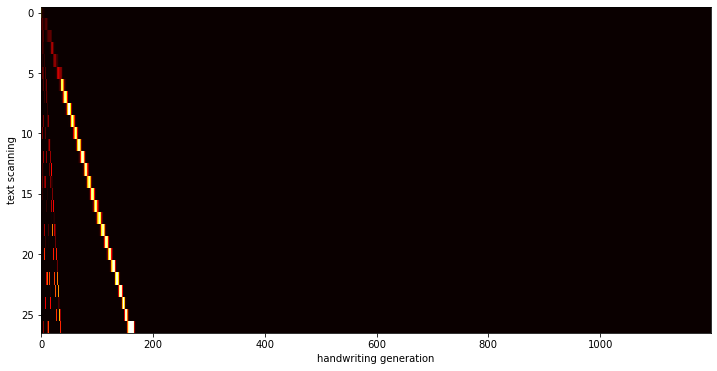

iteration: 7550 of 91000, avg_loss: -2063.75, timeSinceStart: 15632.22, Epoch: 82
iteration: 7600 of 91000, avg_loss: -2062.00, timeSinceStart: 15734.85, Epoch: 83
iteration: 7650 of 91000, avg_loss: -2063.21, timeSinceStart: 15837.24, Epoch: 84
iteration: 7700 of 91000, avg_loss: -2061.97, timeSinceStart: 15939.65, Epoch: 84
iteration: 7750 of 91000, avg_loss: -2067.71, timeSinceStart: 16042.99, Epoch: 85
Can you write this please?


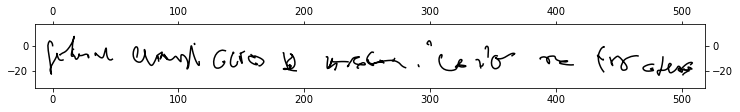

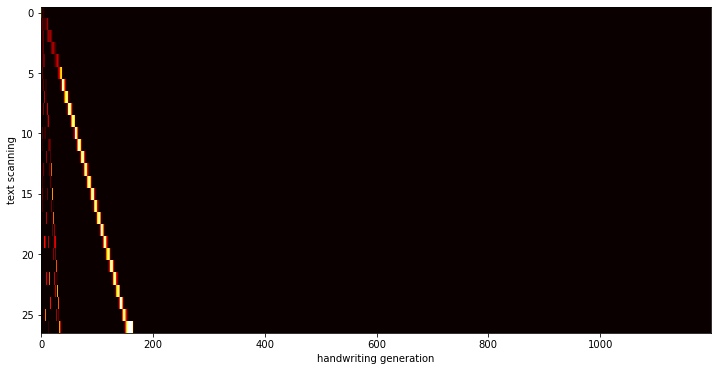

iteration: 7800 of 91000, avg_loss: -2061.67, timeSinceStart: 16148.59, Epoch: 85
iteration: 7850 of 91000, avg_loss: -2062.55, timeSinceStart: 16251.24, Epoch: 86
iteration: 7900 of 91000, avg_loss: -2064.67, timeSinceStart: 16354.60, Epoch: 86
iteration: 7950 of 91000, avg_loss: -2059.49, timeSinceStart: 16458.34, Epoch: 87
iteration: 8000 of 91000, avg_loss: -2067.66, timeSinceStart: 16561.42, Epoch: 87
Can you write this please?


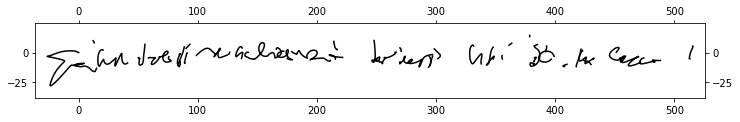

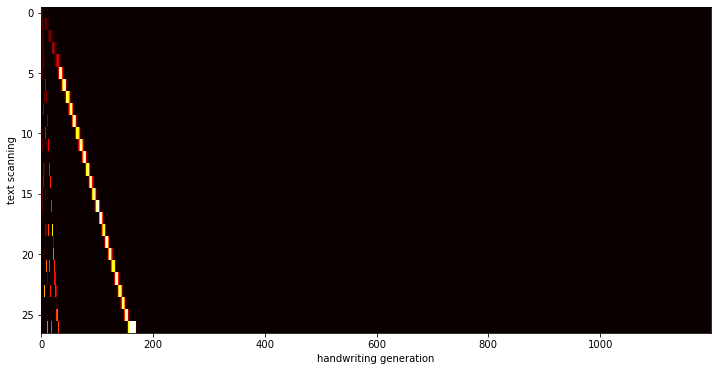

iteration: 8050 of 91000, avg_loss: -2069.97, timeSinceStart: 16666.35, Epoch: 88
iteration: 8100 of 91000, avg_loss: -2063.68, timeSinceStart: 16769.56, Epoch: 89
iteration: 8150 of 91000, avg_loss: -2074.38, timeSinceStart: 16872.35, Epoch: 89
iteration: 8200 of 91000, avg_loss: -2051.21, timeSinceStart: 16975.75, Epoch: 90
iteration: 8250 of 91000, avg_loss: -2071.03, timeSinceStart: 17078.86, Epoch: 90
Can you write this please?


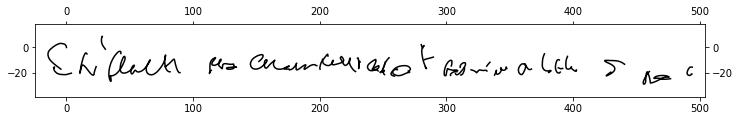

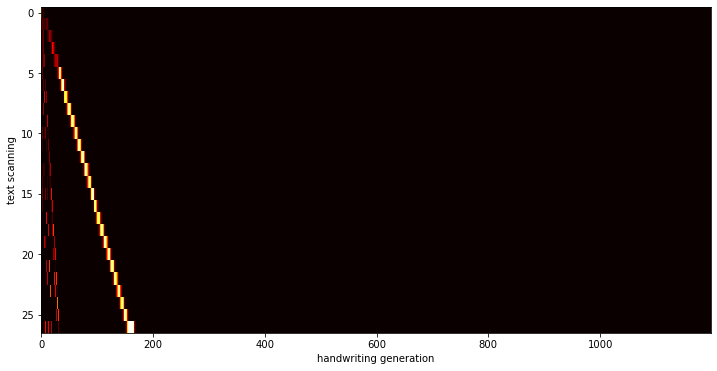

iteration: 8300 of 91000, avg_loss: -2056.11, timeSinceStart: 17184.21, Epoch: 91
iteration: 8350 of 91000, avg_loss: -2066.17, timeSinceStart: 17288.03, Epoch: 91
iteration: 8400 of 91000, avg_loss: -2065.31, timeSinceStart: 17391.33, Epoch: 92
iteration: 8450 of 91000, avg_loss: -2066.58, timeSinceStart: 17495.37, Epoch: 92
iteration: 8500 of 91000, avg_loss: -2059.33, timeSinceStart: 17598.42, Epoch: 93
Can you write this please?


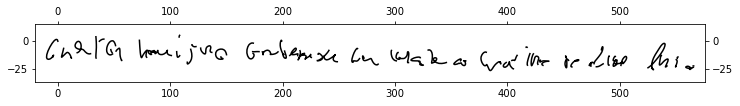

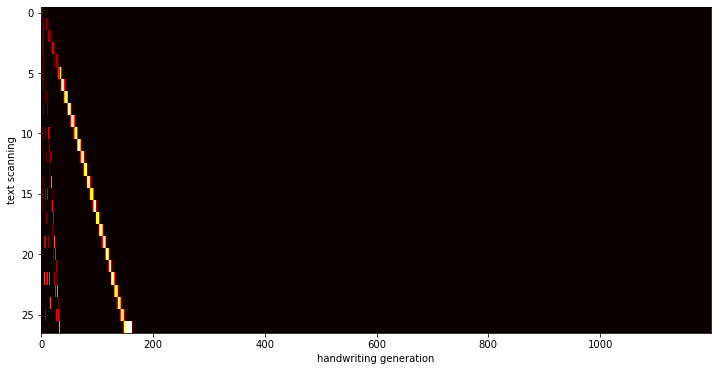

iteration: 8550 of 91000, avg_loss: -2067.07, timeSinceStart: 17703.30, Epoch: 93
iteration: 8600 of 91000, avg_loss: -2066.23, timeSinceStart: 17806.34, Epoch: 94
iteration: 8650 of 91000, avg_loss: -2068.89, timeSinceStart: 17909.27, Epoch: 95
iteration: 8700 of 91000, avg_loss: -2066.00, timeSinceStart: 18013.16, Epoch: 95
iteration: 8750 of 91000, avg_loss: -2054.55, timeSinceStart: 18116.32, Epoch: 96
Can you write this please?


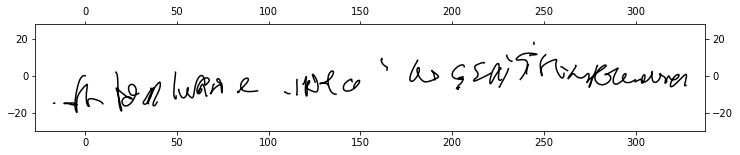

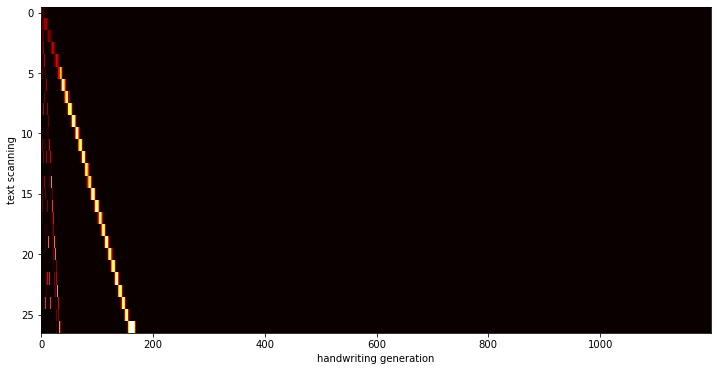

iteration: 8800 of 91000, avg_loss: -2059.46, timeSinceStart: 18221.75, Epoch: 96
iteration: 8850 of 91000, avg_loss: -2073.61, timeSinceStart: 18325.38, Epoch: 97
iteration: 8900 of 91000, avg_loss: -2066.35, timeSinceStart: 18428.67, Epoch: 97
iteration: 8950 of 91000, avg_loss: -2067.35, timeSinceStart: 18530.07, Epoch: 98
iteration: 9000 of 91000, avg_loss: -2061.00, timeSinceStart: 18633.10, Epoch: 98
Can you write this please?


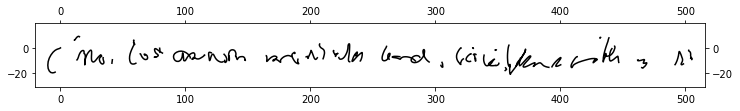

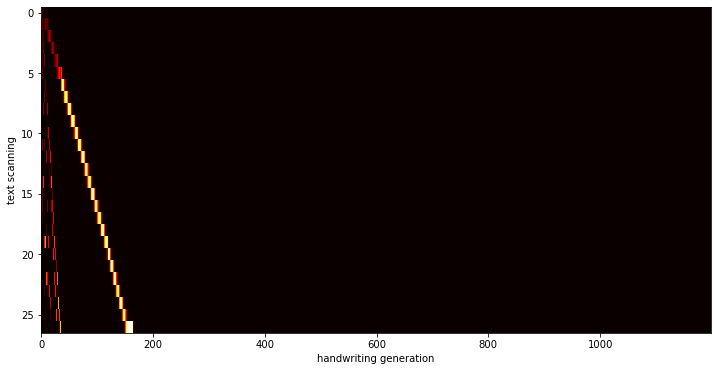

iteration: 9050 of 91000, avg_loss: -2060.66, timeSinceStart: 18737.85, Epoch: 99
iteration: 9100 of 91000, avg_loss: -2063.02, timeSinceStart: 18840.77, Epoch: 100
iteration: 9150 of 91000, avg_loss: -2065.23, timeSinceStart: 18944.50, Epoch: 100
iteration: 9200 of 91000, avg_loss: -2062.11, timeSinceStart: 19047.91, Epoch: 101
iteration: 9250 of 91000, avg_loss: -2062.84, timeSinceStart: 19151.16, Epoch: 101
Can you write this please?


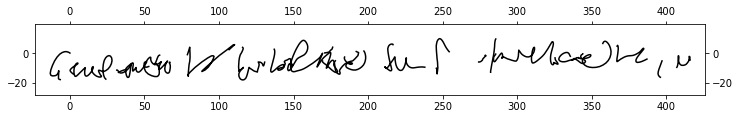

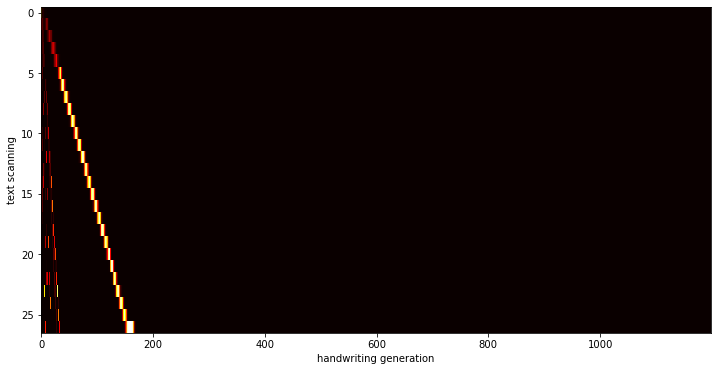

iteration: 9300 of 91000, avg_loss: -2072.55, timeSinceStart: 19255.95, Epoch: 102
iteration: 9350 of 91000, avg_loss: -2064.55, timeSinceStart: 19359.47, Epoch: 102
iteration: 9400 of 91000, avg_loss: -2055.53, timeSinceStart: 19463.18, Epoch: 103
iteration: 9450 of 91000, avg_loss: -2072.64, timeSinceStart: 19565.78, Epoch: 103


In [ ]:
train(model, optim, train_dataloader, n_epochs)